In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [178]:
samples = [
#     'STodd_ms3p0',
    'SToEE_ms0p4',
#     'SToGammaGamma_ms0p4',
#     'SToKPlusKMinus_ms1p5',
#     'SToK0K0_ms1p5',
#     'SToPi0Pi0_ms0p4',
#     'SToPi0Pi0_ms1p0',
#     'SToPiPlusPiMinus_ms0p4',
#     'SToPiPlusPiMinus_ms1p0',

#     'dddd_MH-125_MS-15',
#     'dddd_MH-125_MS-40',
#     'dddd_MH-125_MS-55',
    
#     'bbbb_MH-125_MS-15',
#     'bbbb_MH-125_MS-40',
#     'bbbb_MH-125_MS-55',
    
    '4Tau_MH-125_MS-7',
#     '4Tau_MH-125_MS-15',
#     '4Tau_MH-125_MS-40',
#     '4Tau_MH-125_MS-55',
    'dddd_MH-125_MS-7',

]



In [180]:
%%time

import uproot
import numpy as np

r_csc = {}
r_dt = {}
z_csc = {}
z_dt = {}
    
llp_r = {}
llp_z = {}
weight_llp = {}
decay = 'dddd'

# for m in [ '15', '40','55']:
for sample in samples:
    m = sample

    
    r_csc[m] = []
    r_dt[m] = []
    z_csc[m] = []
    z_dt[m] = []
    llp_r[m] = []
    llp_z[m] =[]
    weight_llp[m] = []
    print(m)
#     if 'EE' not in sample:continue
    analyzer_version = "/v162/"
    if 'MH' in sample:
        
        path = "/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/"+analyzer_version+"normalized/"
        root_dir =uproot.open(path+"ggH_HToSSTo"+sample+".root")

    else: 
        path = "/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v2/"+analyzer_version+"normalized/"
        root_dir =uproot.open(path+"ggH_HToSS_"+sample+".root")
    
    T = root_dir['MuonSystem']
    
    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)
    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()

    
    sel_dt = np.logical_and(T.array('gLLP_decay_vertex_r')>200, T.array('gLLP_decay_vertex_r')<800)
    sel_dt = np.logical_and(sel_dt, np.abs(T.array('gLLP_decay_vertex_z'))<700)

    sel_csc = np.logical_and(np.abs(T.array('gLLP_eta'))<3, np.abs(T.array('gLLP_decay_vertex_z'))<1200)
    sel_csc = np.logical_and(sel_csc, np.abs(T.array('gLLP_decay_vertex_z'))>400)
    
    sel_csc = np.logical_and(sel_csc, T.array('gLLP_decay_vertex_r')<800)
    sel_llp = np.logical_or(sel_dt,sel_csc)

    sel_ev = np.sum(sel_llp,axis = 1) == 1

#     sel_ev   = np.logical_and(sel_ev ,T.array('METNoMuTrigger'))
#     sel_ev = np.logical_and(sel_ev ,T.array('metEENoise') >= 200)
    sel_ev = np.logical_and(sel_ev , sel_jet.sum()>=1)
#     sel_ev = np.logical_and(sel_ev , T.array('Flag2_all'))
    sel_llp = np.logical_or(sel_dt,sel_csc)[sel_ev]

    llp_r[m] += list(np.abs(T.array('gLLP_decay_vertex_r'))[sel_ev][sel_llp])
    llp_z[m] += list(T.array('gLLP_decay_vertex_z')[sel_ev][sel_llp])
    weight_llp[m] += list((T.array('higgsPtWeight')*T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev])
    
    cluster_index = ''

    ########### SELECTION: CLUSTERS ############
    sel_csccluster = T.array('cscRechitCluster'+cluster_index+'_match_gLLP')
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster'+cluster_index+'_match_gLLP_decay_r')<800)
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster'+cluster_index+'_match_gLLP_decay_z'))<1200)
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster'+cluster_index+'_match_gLLP_decay_z'))>400)

    sel_dtcluster = T.array('dtRechitCluster'+cluster_index+'_match_gLLP')
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitCluster'+cluster_index+'_match_gLLP_decay_z'))<700)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitCluster'+cluster_index+'_match_gLLP_decay_r'))<800)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitCluster'+cluster_index+'_match_gLLP_decay_r'))>200)

    sel_ev = np.logical_and(sel_ev,sel_csccluster.sum()+sel_dtcluster.sum()==1)

    r_csc[m] += list(np.abs(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_csccluster][sel_ev].flatten())
    z_csc[m] += list(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_decay_z')[sel_csccluster][sel_ev].flatten())
    r_dt[m] += list(np.abs(T.array('dtRechitCluster' + cluster_index + '_match_gLLP_decay_r'))[sel_dtcluster][sel_ev].flatten())
    z_dt[m] += list(T.array('dtRechitCluster' + cluster_index + '_match_gLLP_decay_z')[sel_dtcluster][sel_ev].flatten())
    



SToEE_ms0p4
4Tau_MH-125_MS-7
dddd_MH-125_MS-7
CPU times: user 4min 59s, sys: 1min 20s, total: 6min 19s
Wall time: 9min 5s


# Efficiency vs. Decay position (2D)


SToEE_ms0p4

4Tau_MH-125_MS-7

dddd_MH-125_MS-7


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/combination_paper/cluster_eff/2D_sig_eff_SToEE_ms0p4.C has been generated
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/combination_paper/cluster_eff/2D_sig_eff_SToEE_ms0p4.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/combination_paper/cluster_eff/2D_sig_eff_SToEE_ms0p4.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning

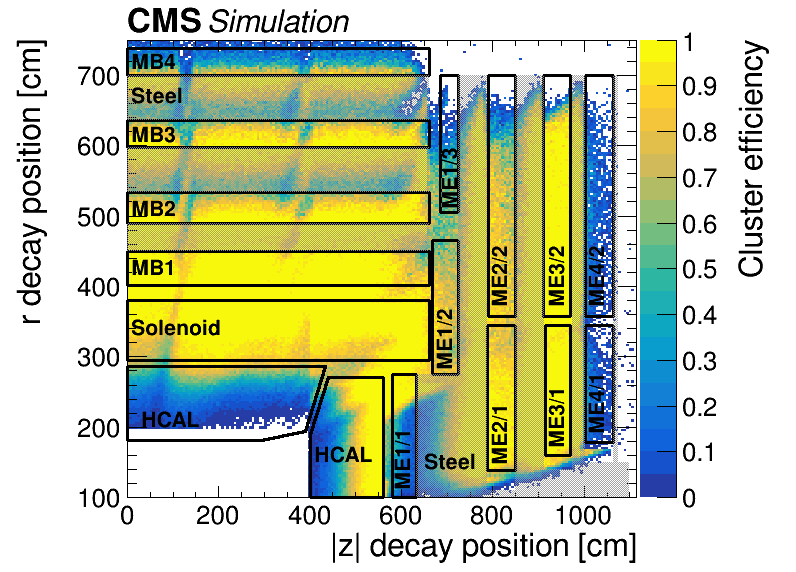

In [190]:
import numpy.ma as ma
import ROOT as rt
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])

# rt.gStyle.SetPaintTextFormat("6.3f")


for i, m in enumerate(samples):
#     if not 'EE' in m:continue
    c = rt.TCanvas('c','c', 800, 600)
    bins = [14, 400+15, 15+1100, 13,100,750]#100-700, CSC analysis

#     bins = [30, -1115, 15+1100, 30,0,750]#100-700

    bins = [200, 0, 15+1100, 200,100,750]#100-700
#     bins = [400, -1115, 15+1100, 200,100,750]#100-700


    title = ['r decay position [cm]', '|z| decay position [cm]']
    if bins[1]<0:
        hm = create_TH2D(np.column_stack((z_csc[m]+z_dt[m],r_csc[m]+r_dt[m])), 'hm1', axis_title = [title[1], title[0], 'Cluster efficiency'], binning=bins)
        hb = create_TH2D(np.column_stack((llp_z[m],llp_r[m])), 'hb1', axis_title = [title[1], title[0],'Cluster efficiency'], binning=bins)
    else:
        hm = create_TH2D(np.abs(np.column_stack((z_csc[m]+z_dt[m],r_csc[m]+r_dt[m]))), 'hm1', axis_title = [title[1], title[0], 'Cluster efficiency'], binning=bins)
        hb = create_TH2D(np.abs(np.column_stack((llp_z[m],llp_r[m]))), 'hb1', axis_title = [title[1], title[0],'Cluster efficiency'], binning=bins)

    pEff1 = rt.TEfficiency(hm,hb)
    hist = hm.Clone()
    
    for y in range(1, hm.GetYaxis().GetNbins()+1):
            for x in range(1, hm.GetXaxis().GetNbins()+1):
                global_bin = pEff1.GetGlobalBin(x,y)
                if pEff1.GetEfficiency(global_bin)<0.01 and pEff1.GetEfficiency(global_bin)>0:
#                     print(hm.GetXaxis().GetBinCenter(x), hm.GetYaxis().GetBinCenter(y), pEff1.GetEfficiency(global_bin))
                    pEff1.SetPassedEvents(global_bin, 0)
#                 elif pEff1.GetEfficiency(global_bin)>0:
#                     if hm.GetXaxis().GetBinCenter(x)>850 and hm.GetXaxis().GetBinCenter(x)<900:
#                         print(hm.GetXaxis().GetBinCenter(x), hm.GetYaxis().GetBinCenter(y), round(pEff1.GetEfficiency(global_bin),2), round(pEff1.GetEfficiencyErrorUp(global_bin),2))


                if x==hm.GetXaxis().GetNbins():pEff1.SetPassedEvents(global_bin, 0)
                hist.SetBinContent(x,y,pEff1.GetEfficiency(global_bin))

#     pEff1.Draw('colz')
    hist.SetMaximum(1.0)
    hist.Draw('colz')

    c.SetTopMargin(0.07)


    c.SetRightMargin(0.2)
    c.Draw()
    
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = 1
    CMS_lumi.extraText   = "Simulation"
#     CMS_lumi.extraText   = "Simulation Preliminary"


    if( iPos==0 ): CMS_lumi.relPosX = 0.15
    # CMS_lumi.CMS_lumi(c, 4, 0)
    CMS_lumi.CMS_lumi(c, 0, iPos)

    boxes = []
    # DT
    boxes.append(rt.TBox(max(bins[1],-661),402,661,449)) #MB1
    boxes.append(rt.TBox(max(bins[1],-661),490,661,533)) #MB2
    boxes.append(rt.TBox(max(bins[1],-661),597,661,636)) #MB3
    boxes.append(rt.TBox(max(bins[1],-661),700,661,738)) #MB4

    boxes.append(rt.TBox(max(bins[1],-661),295,661,380)) #solenoid

    # +z mirror of CSC
    boxes.append(rt.TBox(791,357,850,700)) #ME2/2
    boxes.append(rt.TBox(911,357,970,700)) #ME3/2
    boxes.append(rt.TBox(1002,357,1063,700)) #ME4/2

    boxes.append(rt.TBox(789,139,850,345)) #ME2/1
    boxes.append(rt.TBox(915,160,970,345)) #ME3/1
    boxes.append(rt.TBox(1002,178,1063,345)) #ME4/1

    boxes.append(rt.TBox(580,100,632,275)) #ME1/1
    boxes.append(rt.TBox(668,275,724,465)) #ME1/2
    boxes.append(rt.TBox(686,505,724,700)) #ME1/3
    boxes.append(create_TGraph([400.5,560,560,440,400.5,400.5],[100.5,100.5,270,270,190,100.5])) #hcal endcap
    boxes.append(create_TGraph([433.2, 0.0,0.0,293.5, 390.5, 433.2],[286.4,286.4,181.1,181.1,194.1, 286.4])) #hcal barrel

    
    # -z mirror of CSC
    if bins[1]<0:
        boxes.append(rt.TBox(-791,357,-850,700)) #ME2/2
        boxes.append(rt.TBox(-911,357,-970,700)) #ME3/2
        boxes.append(rt.TBox(-1002,357,-1063,700)) #ME4/2

        boxes.append(rt.TBox(-789,139,-850,345)) #ME2/1
        boxes.append(rt.TBox(-915,160,-970,345)) #ME3/1
        boxes.append(rt.TBox(-1002,178,-1063,345)) #ME4/1

        boxes.append(rt.TBox(-580,100,-632,275)) #ME1/1
        boxes.append(rt.TBox(-668,275,-724,465)) #ME1/2
        boxes.append(rt.TBox(-686,505,-724,700)) #ME1/3
        boxes.append(create_TGraph([-400.5,-560,-560,-440,-400.5,-400.5],[100.5,100.5,270,270,190,100.5])) #hcal
        boxes.append(create_TGraph([-433.2, 0.0,0.0,-293.5, -390.5, -433.2],[286.4,286.4,181.1,181.1,194.1, 286.4])) #hcal barrel

    for b in boxes:
        b.SetFillColorAlpha(15,0)
        b.SetLineWidth(3)
        b.SetLineColor(1)
    #     b.SetFillStyle(3001)
        b.Draw('l same')

    steel = []
    steel.append(rt.TBox(max(bins[1],-661),449,661,490)) #MB1
    steel.append(rt.TBox(max(bins[1],-661),533,661,597)) #MB2
    steel.append(rt.TBox(max(bins[1],-661),636,661,700)) #MB3
    
    x=[633,633, 1100, 1100, 1075, 1075, 1063, 1063,1002,1002,975,975,912,912,849,849,789,789,724,724, 633]
    y=[275, 100, 100, 150, 150, 700,700,150,150,700,700,140,140,700,700,110,110,700,700,275,275]
    steel.append(create_TGraph(x,y)) 



    for b in steel:
#         b.SetFillColorAlpha(15,0.5)
        b.SetFillStyle(3001)
        b.SetFillColorAlpha(15,0.9)
        b.Draw('fsame')

    
    text = rt.TLatex()
    text.SetTextSize(0.04)


    

    text.DrawLatex(bins[1]+10, 415, "MB1")
    text.DrawLatex(bins[1]+10, 500, "MB2")
    text.DrawLatex(bins[1]+10, 605, "MB3")
    text.DrawLatex(bins[1]+10, 708, "MB4")

    text.DrawLatex(650, 140, "Steel")
    text.DrawLatex(bins[1]+10,660, "Steel")
    text.DrawLatex(bins[1]+10, 330, "Solenoid")
    text.DrawLatex(bins[1]+30, 200, "HCAL")
    text.DrawLatex(410, 150, "HCAL")

    text.SetTextAngle(90)
    ring2_r = 370
    text.DrawLatex(620, 110, "ME1/1")
    text.DrawLatex(712, 280, "ME1/2")
    text.DrawLatex(722, 510, "ME1/3")

    text.DrawLatex(832, 145, "ME2/1")
    text.DrawLatex(832, ring2_r, "ME2/2")

    text.DrawLatex(957, 170, "ME3/1")
    text.DrawLatex(957, ring2_r, "ME3/2")

    text.DrawLatex(1045, 190, "ME4/1")
    text.DrawLatex(1045, ring2_r, "ME4/2")


    outDir = "/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/combination_paper/cluster_eff/"
    print(m)
    if not os.path.isdir(outDir):os.makedirs(outDir)
    if CMS_lumi.extraText == 'Simulation Preliminary':
        c.SaveAs(outDir+"2D_sig_eff_"+m+"_pas.C")
        c.SaveAs(outDir+"2D_sig_eff_"+m+"_pas.pdf")
        c.SaveAs(outDir+"2D_sig_eff_"+m+"_pas.png")
    else:
        c.SaveAs(outDir+"2D_sig_eff_"+m+".C")
        c.SaveAs(outDir+"2D_sig_eff_"+m+".png")
        c.SaveAs(outDir+"2D_sig_eff_"+m+".pdf")


# 1d efficiency, all samples in 1 plot

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/combination_paper/cluster_eff/csc_1D_sig_eff.C has been generated
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/combination_paper/cluster_eff/csc_1D_sig_eff.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/us

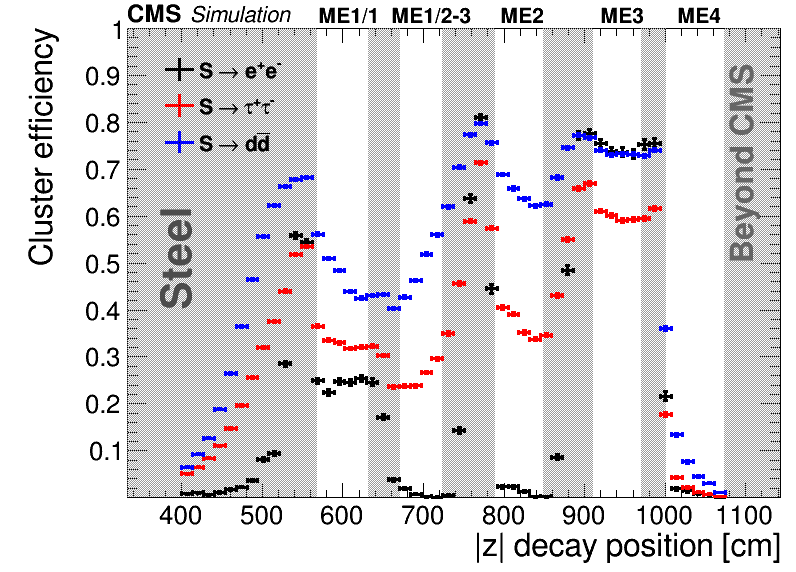

In [240]:
import numpy.ma as ma
import ROOT as rt
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])

bins = [50, 400, 1075]
xaxis_title = '|z| decay position [cm]'

leg = rt.TLegend(0.2,0.72,0.4,0.91)
leg.SetTextSize(0.04)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
leg.SetFillStyle(0)

c = rt.TCanvas('c','c', 800, 600)
pEff= {}
for i,m in enumerate(samples):
    hm = create_TH1D(np.abs(z_csc[m]), 'hb1', axis_title = [xaxis_title,'Cluster efficiency'], binning=bins)
    hb = create_TH1D(np.abs(llp_z[m]), 'hb1', axis_title = [xaxis_title,'Cluster efficiency'], binning=bins)
    pEff[m] = rt.TEfficiency(hm,hb)
    pEff[m].SetLineColor(std_color_list[i])
    pEff[m].SetLineWidth(3)

    if 'EE' in m:leg.AddEntry(pEff[m], 'S #rightarrow e^{+}e^{-}','lpe3')
    elif 'dd' in m:leg.AddEntry(pEff[m], 'S #rightarrow d#bar{d}','LPE4')
    else:leg.AddEntry(pEff[m], 'S #rightarrow #tau^{+}#tau^{-}','LPE5')
        
        
    pEff[m].Draw('' if i == 0 else 'Psame')
c.Draw()
    
leg.Draw()
pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetYaxis().SetTitleOffset(0.0);



# ymax = pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetMaximum()
# ymin = pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetMinimum()
xmin = pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetXaxis().GetXmin()
xmax = pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().GetXaxis().GetXmax()
ymax = 1
ymin = 0
pEff[list(pEff.keys())[0]].GetPaintedGraph().GetHistogram().SetMaximum(ymax)

boxes = []

boxes.append(rt.TBox(xmin,ymin,568,ymax)) #in front of ME11
boxes.append(rt.TBox(632,ymin,671,ymax)) #between ME11 and ME12
boxes.append(rt.TBox(724,ymin,789,ymax)) #between ME12 and station2
boxes.append(rt.TBox(849,ymin,911,ymax)) #between station2 and station3
boxes.append(rt.TBox(970,ymin,1002,ymax)) #between station3 and station4
boxes.append(rt.TBox(1073,ymin,xmax,ymax)) #beyond CMS
for b in boxes:
    b.SetFillColor(15)
    b.SetFillStyle(3001)
    b.Draw('same')


l = rt.TLatex()
l.SetTextSize(0.08)
l.SetTextColor(12)
l.SetTextAngle(90)
l.DrawLatex(xmin+80, ymax*0.4, "Steel")

l2 = rt.TLatex()
l2.SetTextSize(0.06)
l2.SetTextColor(13)
l2.SetTextAngle(90)
l2.DrawLatex(1110, ymax*0.5, "Beyond CMS")
text = rt.TLatex()
text.SetTextSize(0.04)
text.DrawLatex(570, ymax*1.01, "ME1/1")
text.DrawLatex(660, ymax*1.01, "ME1/2-3")
text.DrawLatex(795, ymax*1.01, "ME2")
text.DrawLatex(920, ymax*1.01, "ME3")
text.DrawLatex(1015, ymax*1.01, "ME4")

CMS_lumi.cmsText     = "CMS"
CMS_lumi.relPosX = 0.09
CMS_lumi.relPosY = 0.0
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation"
#         CMS_lumi.extraText   = "Simulation Supplementary"


CMS_lumi.CMS_lumi(c, 0, 0)



for k,v in pEff.items():pEff[k].Draw('same')
leg.Draw()

c.Draw()


outDir = "/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer//plots/MuonSystem_Analysis/combination_paper/cluster_eff/"
if not os.path.isdir(outDir):os.makedirs(outDir)
if CMS_lumi.extraText == 'Simulation Preliminary':
    c.SaveAs(outDir+"csc_1D_sig_eff_pas.C")
    c.SaveAs(outDir+"csc_1D_sig_eff_pas.pdf")
    c.SaveAs(outDir+"csc_1D_sig_eff_pas.png")
else:
    c.SaveAs(outDir+"csc_1D_sig_eff.C")
    c.SaveAs(outDir+"csc_1D_sig_eff.png")
    c.SaveAs(outDir+"csc_1D_sig_eff.pdf")
